<ipython-input-3-8cd43ae39b1c>:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


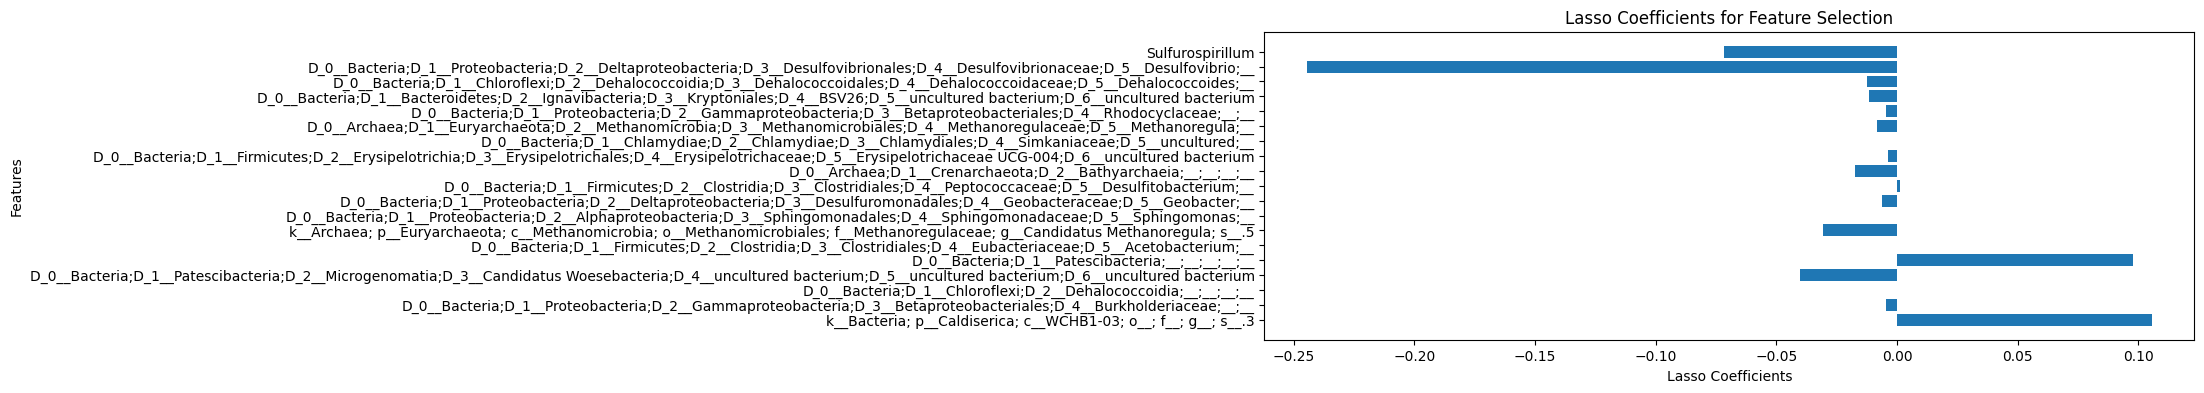

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:962: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


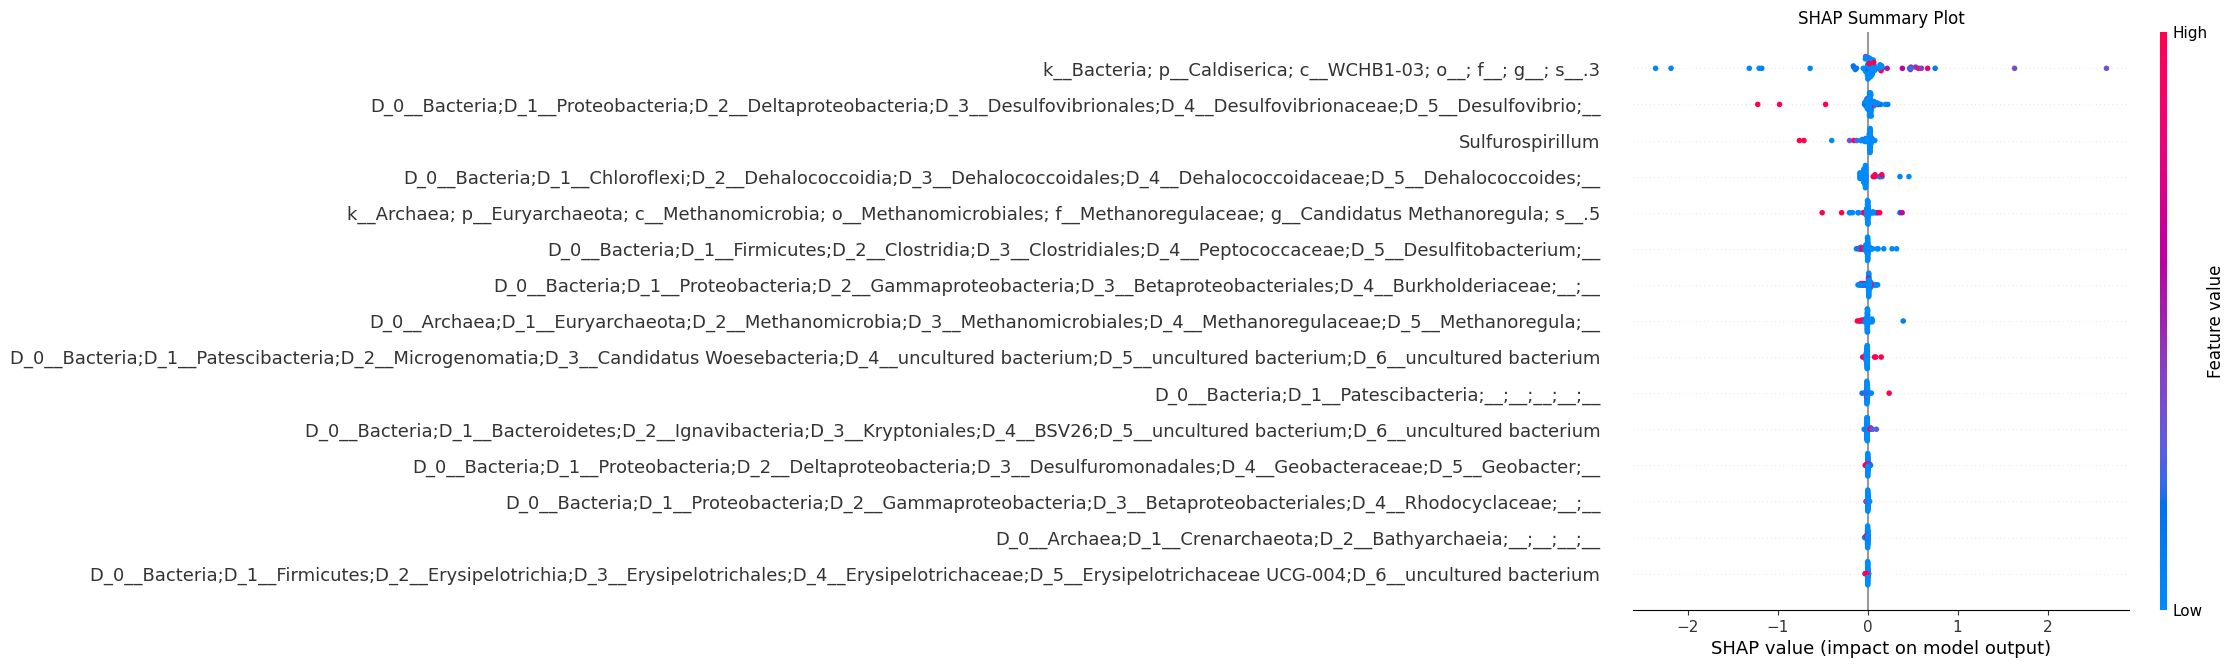

                                              feature  importance
14  k__Bacteria; p__Caldiserica; c__WCHB1-03; o__;...    0.560568
10  k__Archaea; p__Euryarchaeota; c__Methanomicrob...    0.097933
1   D_0__Bacteria;D_1__Proteobacteria;D_2__Deltapr...    0.097489
0                                    Sulfurospirillum    0.078140
8   D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...    0.032226
5   D_0__Archaea;D_1__Euryarchaeota;D_2__Methanomi...    0.031760
2   D_0__Bacteria;D_1__Chloroflexi;D_2__Dehalococc...    0.028600
11  D_0__Bacteria;D_1__Patescibacteria;__;__;__;__;__    0.018041
13  D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...    0.017365
12  D_0__Bacteria;D_1__Patescibacteria;D_2__Microg...    0.010472
3   D_0__Bacteria;D_1__Bacteroidetes;D_2__Ignaviba...    0.009361
9   D_0__Bacteria;D_1__Proteobacteria;D_2__Deltapr...    0.008608
7   D_0__Archaea;D_1__Crenarchaeota;D_2__Bathyarch...    0.004654
4   D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...    0.003244
6   D_0__B

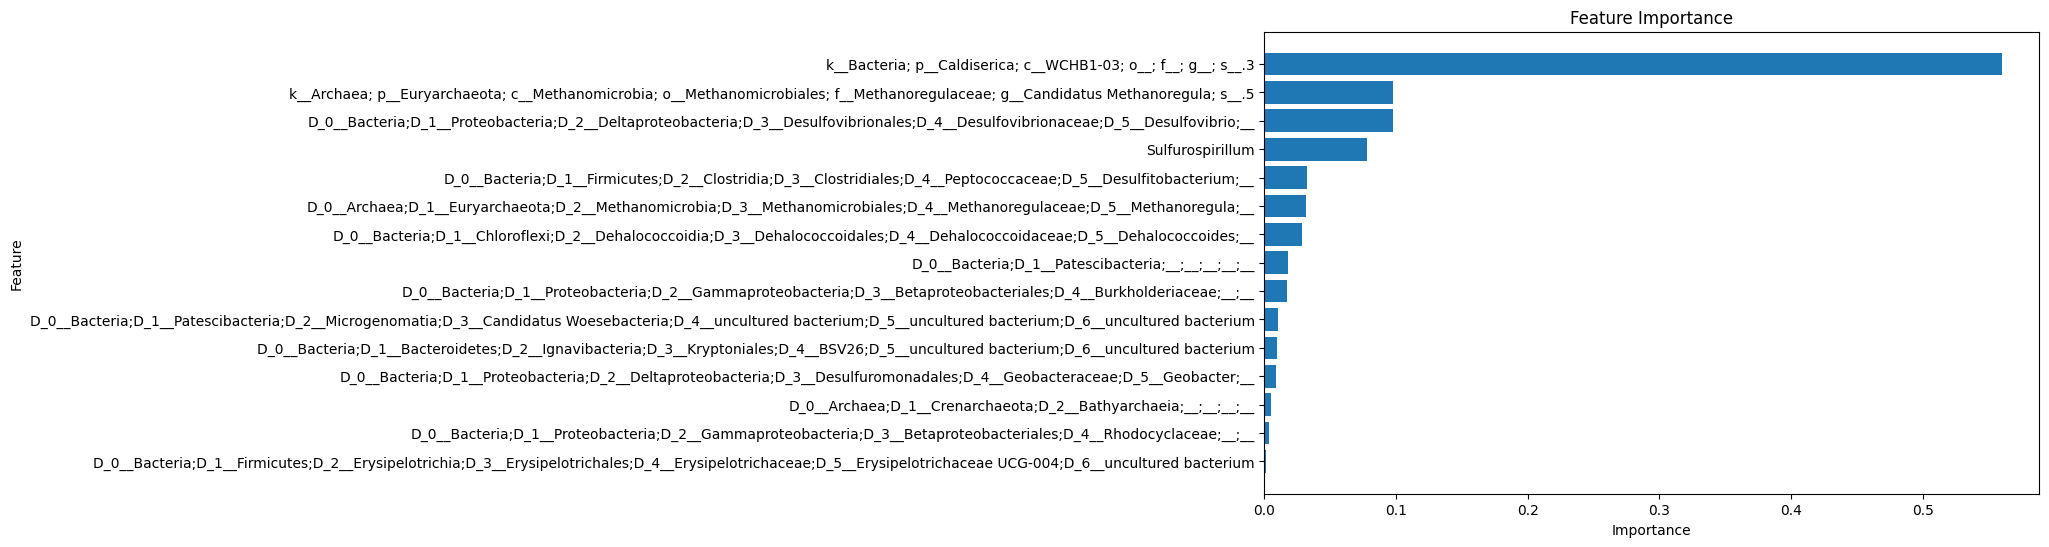

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

data = pd.read_csv('data_top_20.csv')

data.replace('ND', np.nan, inplace=True)

imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_imputed), columns=data_imputed.columns)

X = data_scaled.drop(columns=['PCE_delta13C'])
y = data_scaled['PCE_delta13C']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

plt.figure(figsize=(12, 4))
plt.barh(X_train.columns, lasso.coef_)
plt.ylabel('Features')
plt.xlabel('Lasso Coefficients')
plt.title('Lasso Coefficients for Feature Selection')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('lasso_coefficients.png')
plt.show()

selected_features = X_train.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_selected)

shap.summary_plot(shap_values, X_train_selected, show=False)
plt.title('SHAP Summary Plot')
plt.savefig('shap_summary_plot.png')
plt.show()

feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train_selected.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

feature_importance_df.to_csv('feature_importance.csv', index=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.savefig('feature_importance_barh.png')
plt.show()


In [2]:
!pip install scikit-optimize shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 6.5 MB/s eta 0:00:00


In [1]:
import pandas as pd

file_path = 'EDCPCE-replace0toNan.xlsx'
data = pd.read_excel(file_path)

data.replace('ND', pd.NA, inplace=True)

data_filtered = data[data['PCE_delta13C'].notnull()]
data_filtered = data_filtered.iloc[:48]

data_filtered = data_filtered.iloc[:, 1:]

filtered_file_path = 'filtered_data_new.xlsx'
data_filtered.to_excel(filtered_file_path, index=False)

print(f"Filtered data saved to {filtered_file_path}")


Filtered data saved to filtered_data.xlsx


In [1]:
import pandas as pd

file_path = 'EDCPCE-replace0toNan.xlsx'
data = pd.read_excel(file_path)

data.replace('ND', pd.NA, inplace=True)

# Only keep rows with values ​​in the PCE_delta13C column
data_filtered = data[data['PCE_delta13C'].notnull()]

data_filtered = data_filtered.iloc[:48]

data_filtered = data_filtered.iloc[:, 1:]

data_filtered.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in data_filtered.columns]

# Identify bacteria data
def is_bacteria(column_name):
    return column_name.startswith('D_0__Bacteria;') or column_name.startswith('k__Bacteria;')

# Bacteria data column
bacteria_columns = [col for col in data_filtered.columns if is_bacteria(col)]

bacteria_data = data_filtered[bacteria_columns]

#Total number of bacteria
data_filtered['Total_Bacteria'] = bacteria_data.sum(axis=1)

# List of chlorine compounds
chlorinated_compounds_list = [
    "1,1,2,2-tetrachloroethane",
    "1,1,2-trichloroethane",
    "1,1,1-trichloroethane",
    "1,1,2,2-tetrachloroethane",
    "1,2-dichloroethane",
    "Carbon tetrachloride",
    "Chloroform",
    "Dichloromethane",
    "Tetrachloroethene",
    "Trichloroethene",
    "cis-1,2-dichloroethene",
    "Vinyl chloride"
]

# Total chlorine compounds
def is_chlorinated_compound(column_name):
    return any(compound in column_name for compound in chlorinated_compounds_list)

chlorinated_compounds_columns = [col for col in data_filtered.columns if is_chlorinated_compound(col)]
print(f"Identified chlorinated compound columns: {chlorinated_compounds_columns}")

data_filtered['Sum_Chlorinated_Compounds'] = data_filtered[chlorinated_compounds_columns].sum(axis=1)

# Sulfur chemical characteristics
sulphur_chemistry_columns = [
    col for col in data_filtered.columns
    if 'sulfate' in col.lower() or 'sulphide' in col.lower()
]
data_filtered['Sum_Sulphur_Chemistry'] = data_filtered[sulphur_chemistry_columns].sum(axis=1)

filtered_file_path = 'filtered_data_new.xlsx'
data_filtered.to_excel(filtered_file_path, index=False)

print(f"Filtered data saved to {filtered_file_path}")


Identified chlorinated compound columns: ['"1,1,1-trichloroethane"', '"1,1,2,2-tetrachloroethane"', '"1,1,2-trichloroethane"', '"1,2-dichloroethane"', 'Carbon tetrachloride', 'Chloroform', '"cis-1,2-dichloroethene"', 'Dichloromethane', 'Trichloroethene', 'Tetrachloroethene', 'Vinyl chloride']
Filtered data saved to filtered_data_new.xlsx


Deleted 10 columns with all missing values.
Remaining 5714 columns.
Number of selected features using Lasso: 579
Number of selected features using RandomForest after Lasso: 290
Best XGBoost params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}

Train Set Metrics:
Mean Squared Error: 35.26590672508218
R² Score: 0.4465411113828378
Mean Absolute Error: 4.002960873479429
Root Mean Squared Error: 5.938510480337825
Mean Absolute Percentage Error: 0.2791317942120221
Explained Variance Score: 0.4466218534200719
Adjusted R² Score: 1.04543319234917

Test Set Metrics:
Mean Squared Error: 56.32061500413872
R² Score: 0.20835346122250087
Mean Absolute Error: 6.354790599822998
Root Mean Squared Error: 7.504706190394047
Mean Absolute Percentage Error: 0.5346502833679679
Explained Variance Score: 0.33936549528688953
Adjusted R² Score: 1.0138885357680263


/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


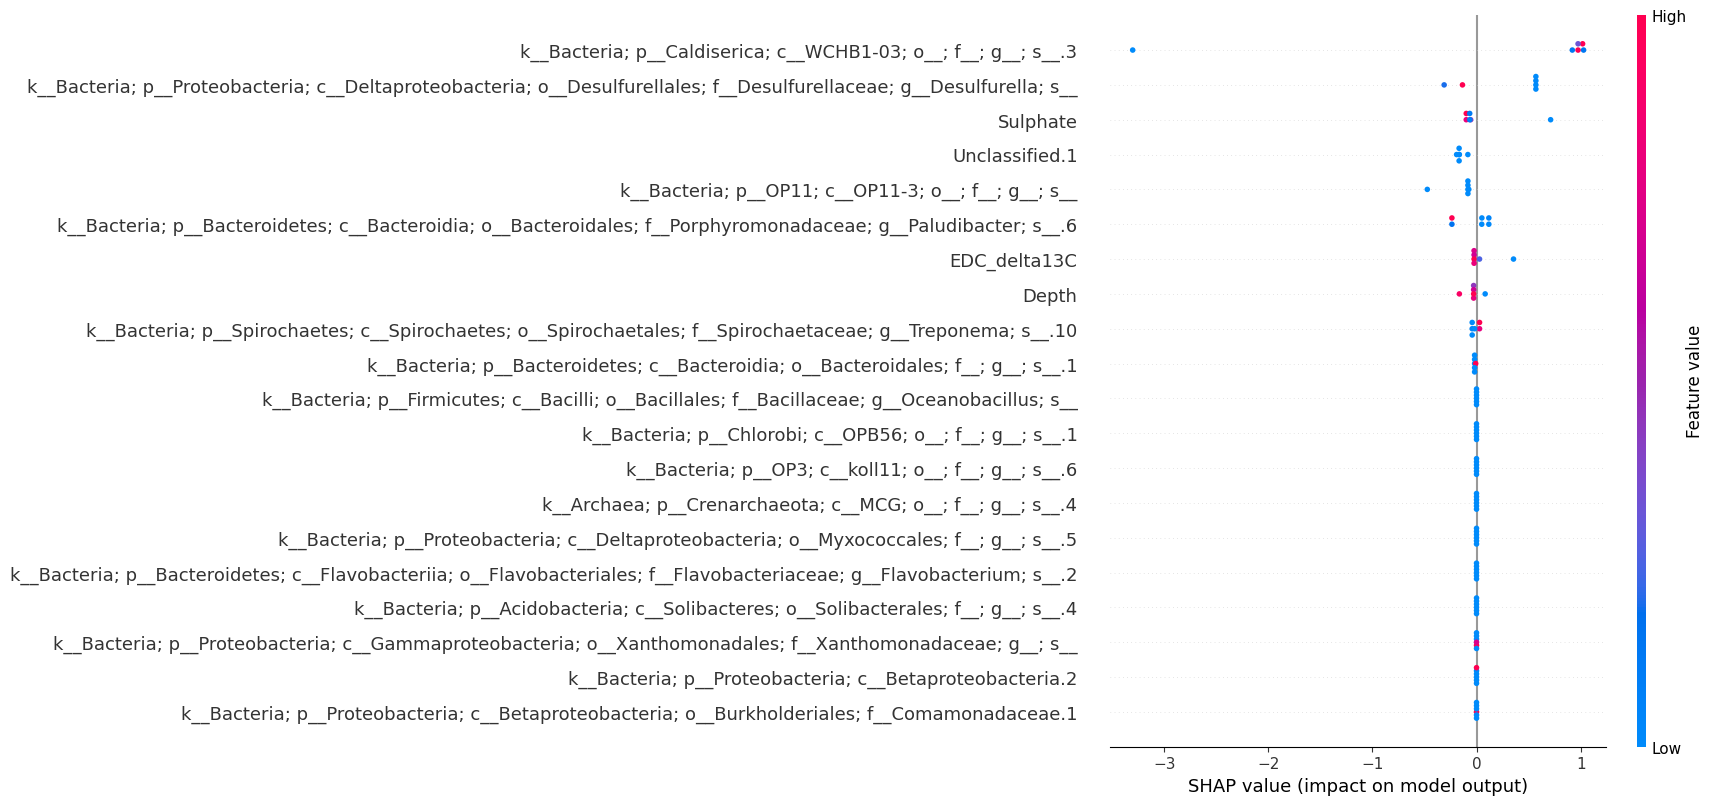

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import shap
import matplotlib.pyplot as pl

file_path = 'filtered_data.xlsx'
data = pd.read_excel(file_path)

# y PCE_delta13C
all_columns = data.columns.tolist()
target_column = 'PCE_delta13C'

# Extra Trees Regressor
X_full = data.drop(columns=[target_column])
y_full = data[target_column]

# Remove all columns with missing values
X_full = X_full.dropna(axis=1, how='all')
print(f"Deleted {data.shape[1] - X_full.shape[1]} columns with all missing values.")
print(f"Remaining {X_full.shape[1]} columns.")

# Extra Trees Regressor
imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=50, random_state=42), max_iter=10, random_state=42)
X_full_imputed = pd.DataFrame(imputer.fit_transform(X_full), columns=X_full.columns)

# Separate features and target variables
X = X_full_imputed
y = y_full

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# LassoCV
lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1], cv=5, max_iter=10000)
lasso.fit(X_train, y_train)
model_lasso = SelectFromModel(lasso, prefit=True)
X_train_lasso = model_lasso.transform(X_train)
X_test_lasso = model_lasso.transform(X_test)

# print feature
selected_lasso_features = X.columns[model_lasso.get_support()].tolist()
print("Number of selected features using Lasso:", len(selected_lasso_features))

# rf
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_lasso, y_train)
model_rf = SelectFromModel(rf, threshold='median', prefit=True)
X_train_rf = model_rf.transform(X_train_lasso)
X_test_rf = model_rf.transform(X_test_lasso)

selected_rf_features = [selected_lasso_features[i] for i in range(len(selected_lasso_features)) if model_rf.get_support()[i]]
print("Number of selected features using RandomForest after Lasso:", len(selected_rf_features))

# XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_cv = GridSearchCV(xg_reg, xgb_params, cv=5)
xgb_cv.fit(X_train_rf, y_train)

print("Best XGBoost params:", xgb_cv.best_params_)

# Optimal parameters
xg_reg_best = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=xgb_cv.best_params_['learning_rate'],
    max_depth=xgb_cv.best_params_['max_depth'],
    n_estimators=xgb_cv.best_params_['n_estimators'],
    random_state=42
)
xg_reg_best.fit(X_train_rf, y_train)

# pridict
y_train_pred = xg_reg_best.predict(X_train_rf)
y_test_pred = xg_reg_best.predict(X_test_rf)

# Evaluate the model on the training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
explained_variance_train = explained_variance_score(y_train, y_train_pred)
adjusted_r2_train = 1 - (1 - r2_train) * (len(y_train) - 1) / (len(y_train) - X_train_rf.shape[1] - 1)

print("\nTrain Set Metrics:")
print("Mean Squared Error:", mse_train)
print("R² Score:", r2_train)
print("Mean Absolute Error:", mae_train)
print("Root Mean Squared Error:", rmse_train)
print("Mean Absolute Percentage Error:", mape_train)
print("Explained Variance Score:", explained_variance_train)
print("Adjusted R² Score:", adjusted_r2_train)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
explained_variance_test = explained_variance_score(y_test, y_test_pred)
adjusted_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test_rf.shape[1] - 1)

print("\nTest Set Metrics:")
print("Mean Squared Error:", mse_test)
print("R² Score:", r2_test)
print("Mean Absolute Error:", mae_test)
print("Root Mean Squared Error:", rmse_test)
print("Mean Absolute Percentage Error:", mape_test)
print("Explained Variance Score:", explained_variance_test)
print("Adjusted R² Score:", adjusted_r2_test)

# SHAP
explainer = shap.Explainer(xg_reg_best)
shap_values = explainer(X_test_rf)
pl.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_rf, feature_names=selected_rf_features)
